<a href="https://www.kaggle.com/code/abhirupghosh184098/house-prices-advanced-regression-techniques?scriptVersionId=113133156" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Competition: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

## [Short Description](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/description) (and Disclaimer)

This is a “getting started” competition, where we use information describing (almost) every aspect of residential homes in Ames, Iowa, to predict the final price of each home. I used the [Feature Engineering course on Kaggle](https://www.kaggle.com/learn/feature-engineering) to help me get started, and a lot of the code in this notebook is from that course.

## [Evaluation](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$
where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

## [Data](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

### Training set: train.csv
* **SalePrice**: the property's sale price in dollars and our target variable
* 79 explanatory variables describing (almost) every aspect of residential homes

### Test set: test.csv

### Data description: data_description.txt

Full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here

### Submission file: sample_submission.csv
a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Preliminaries

## Dependencies

In [2]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from fastai.tabular.all import *
import seaborn as sns


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

import warnings
warnings.simplefilter('ignore', FutureWarning)


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

# Competition data

In [3]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Data cleaning + Feature Engineering

In [4]:
df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [5]:
[print(f"{col:25}\t{df[col].dtype}\t{df[col].nunique()}") for col in df.columns];

Id                       	int64	1460
MSSubClass               	int64	15
MSZoning                 	object	5
LotFrontage              	float64	110
LotArea                  	int64	1073
Street                   	object	2
Alley                    	object	2
LotShape                 	object	4
LandContour              	object	4
Utilities                	object	2
LotConfig                	object	5
LandSlope                	object	3
Neighborhood             	object	25
Condition1               	object	9
Condition2               	object	8
BldgType                 	object	5
HouseStyle               	object	8
OverallQual              	int64	10
OverallCond              	int64	9
YearBuilt                	int64	112
YearRemodAdd             	int64	61
RoofStyle                	object	6
RoofMatl                 	object	8
Exterior1st              	object	15
Exterior2nd              	object	16
MasVnrType               	object	4
MasVnrArea               	float64	327
ExterQual                	object	4
ExterCo

In [6]:
# Combine the ["MoSold","YrSold"] columns into a single datetime column ['DateSold'] 
# and drop the original columns; make a bunch of new columns out of the new ['DateSold'] col

df['DateSold'] = pd.to_datetime(df.YrSold.astype(str) + '/' + df.MoSold.astype(str) + '/01')
df.drop(['MoSold', 'YrSold'], axis=1, inplace=True)
add_datepart(df, 'DateSold')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,DateSoldYear,DateSoldMonth,DateSoldWeek,DateSoldDay,DateSoldDayofweek,DateSoldDayofyear,DateSoldIs_month_end,DateSoldIs_month_start,DateSoldIs_quarter_end,DateSoldIs_quarter_start,DateSoldIs_year_end,DateSoldIs_year_start,DateSoldElapsed
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,WD,Normal,208500,2008,2,5,1,4,32,False,True,False,False,False,False,1.201824e+09
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,WD,Normal,181500,2007,5,18,1,1,121,False,True,False,False,False,False,1.177978e+09
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,WD,Normal,223500,2008,9,36,1,0,245,False,True,False,False,False,False,1.220227e+09
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,WD,Abnorml,140000,2006,2,5,1,2,32,False,True,False,False,False,False,1.138752e+09
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,WD,Normal,250000,2008,12,49,1,0,336,False,True,False,False,False,False,1.228090e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,WD,Normal,175000,2007,8,31,1,2,213,False,True,False,False,False,False,1.185926e+09
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Mi

In [7]:
dep_var = 'SalePrice' # dependent variable
df[dep_var] = np.log(df[dep_var]) # evaluation criterion is the RMSE of the logarithm

In [8]:
# separate continuous and categorial variables based on cardinality
cont,cat = cont_cat_split(df, 25, dep_var=dep_var) # the highest categorical data had cardinality = 25

In [9]:
print(cont)
print(cat)

['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'DateSoldElapsed']
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 

In [10]:
# Categorify: https://docs.fast.ai/tabular.core.html#Categorify
# FillMissing: https://docs.fast.ai/tabular.core.html#FillMissing
# Normalize: https://docs.fast.ai/data.transforms.html#Normalize
procs = [Categorify, FillMissing, Normalize]

In [11]:
# This is not an extrapolation problem; the test set does not contain points 
# boyond the region of validity of the training set; hence, we do a random 80-20 split
# of the training set into train + valid

splits = RandomSplitter(valid_pct=0.3, seed=0)(range_of(df))

In [12]:
# TabularPandas: https://docs.fast.ai/tabular.core.html#TabularPandas
to = TabularPandas(df, procs, cat, cont, dep_var, splits=splits)

In [13]:
print(cont)
print(cat)

['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'DateSoldElapsed']
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 

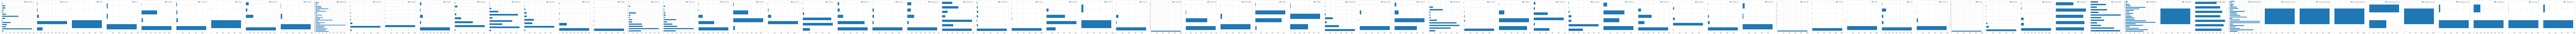

In [14]:
fig, axs = plt.subplots(ncols=len(cat), nrows=1, figsize=(len(cat)*5, 5))

for idx, col in enumerate(cat):
    to.train.xs[col].value_counts(sort=False).plot.barh(ax=axs[idx], label=col)
    axs[idx].legend()

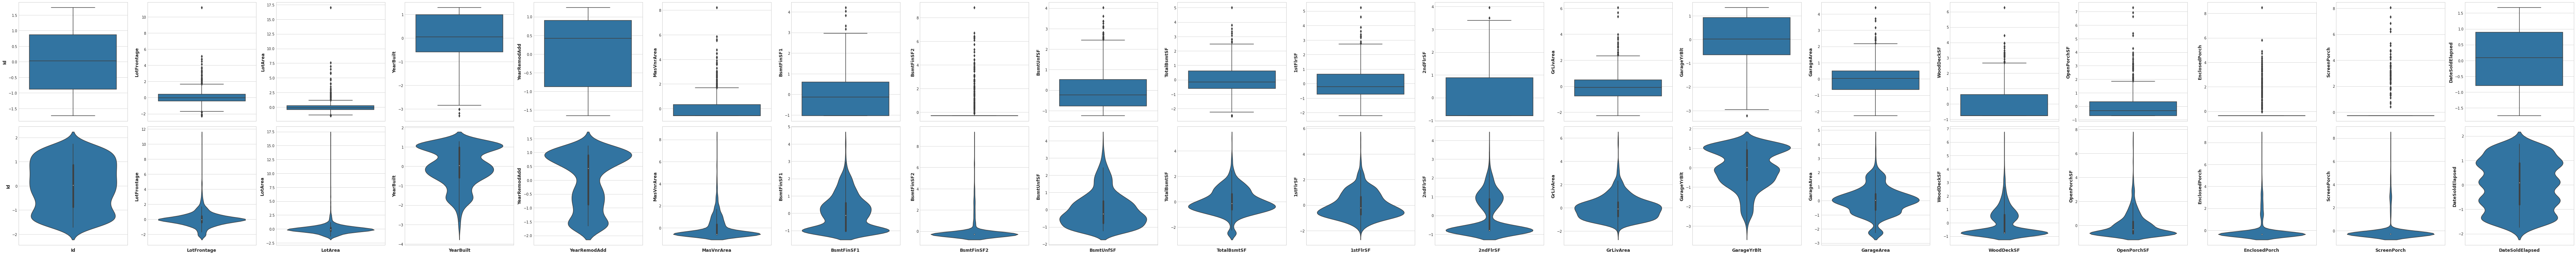

In [15]:
fig, axs = plt.subplots(ncols=len(cont), nrows=2, figsize=(len(cont)*5, 10))

for idx, col in enumerate(cont):
    sns.boxplot(y=to.train.xs[col], ax=axs[0,idx])
    sns.violinplot(y=to.train.xs[col], ax=axs[1,idx])
    axs[1,idx].set_xlabel(col)

OUTLIERS?

In [16]:
# Metrics for evaluation: Root-Mean-Squared-Error (RMSE) between the logarithm of the 
# predicted value and the logarithm of the observed sales price
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [17]:
# Split into train + valid

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
len(to.train),len(to.valid)

(1022, 438)

# Model Building

## Decision Tree Regressor

In [18]:
dtr = DecisionTreeRegressor()
dtr.fit(xs, y)
m_rmse(dtr, xs, y), m_rmse(dtr, valid_xs, valid_y)

(0.0, 0.205505)

This gives a 0.0 training set error (exact predictions), but generalises badly to the validation set. Hence we do some hyperparameter tuning.

In [19]:
# Hyperparameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {"splitter": ["best", "random"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              "min_weight_fraction_leaf": [0.1, 0.3, 0.5],
              }

dtr = DecisionTreeRegressor()

clf = GridSearchCV(estimator=dtr, 
                   param_grid=param_grid,
                   scoring='neg_root_mean_squared_error',
                   n_jobs=-1)

clf.fit(xs, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_))

Best parameters: {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Lowest RMSE:  0.22461746078812733


In [20]:
# Ouptut: Best parameters: {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
# Lowest RMSE:  0.2349359993399057

# Saving the output so that we don't run the above cell multiple times

In [21]:
dtr = DecisionTreeRegressor(max_depth=6, max_leaf_nodes=20, 
                          min_samples_leaf=20, min_samples_split=10,
                         min_weight_fraction_leaf=0.1)
dtr.fit(xs, y)
m_rmse(dtr, xs, y), m_rmse(dtr, valid_xs, valid_y)

(0.215144, 0.234927)

## Random Forest Regressor

In [22]:
rfr = RandomForestRegressor()
rfr.fit(xs, y)
m_rmse(rfr, xs, y), m_rmse(rfr, valid_xs, valid_y)

(0.056528, 0.140433)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [5,20,50,100],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
               'min_samples_split': [2, 6, 10],
               'min_samples_leaf': [1, 3, 4],
               'bootstrap': [True, False]}


rfr = RandomForestRegressor()

clf = RandomizedSearchCV(estimator=rfr, 
                   param_distributions=random_grid,
                   scoring='neg_root_mean_squared_error',
                   n_jobs=-1)

clf.fit(xs, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_))

Best parameters: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Lowest RMSE:  0.14788269680597346


In [24]:
# Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}
# Lowest RMSE:  0.1509913147378329

In [25]:
def rf(xs, y, n_estimators=100, min_samples_split=6, min_samples_leaf=4,
       max_features='sqrt',max_depth=20, bootstrap=True, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 max_depth=max_depth,
                                 oob_score=True).fit(xs, y)

In [26]:
rfr = rf(xs, y)
m_rmse(rfr, xs, y), m_rmse(rfr, valid_xs, valid_y)

(0.107632, 0.149791)

### Plotting feature importance

In [27]:
def rf_feat_importance(rfr, df):
    return pd.DataFrame({'cols':df.columns, 'imp':rfr.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [28]:
fi = rf_feat_importance(rfr, xs)
fi[:10]

,cols,imp
14,OverallQual,0.102564
86,GrLivArea,0.084020
83,TotalBsmtSF,0.066646
77,YearBuilt,0.061642
88,GarageArea,0.054094
36,FullBath,0.051618
84,1stFlrSF,0.049632
47,GarageCars,0.045957
40,KitchenQual,0.044926
21,ExterQual,0.038169


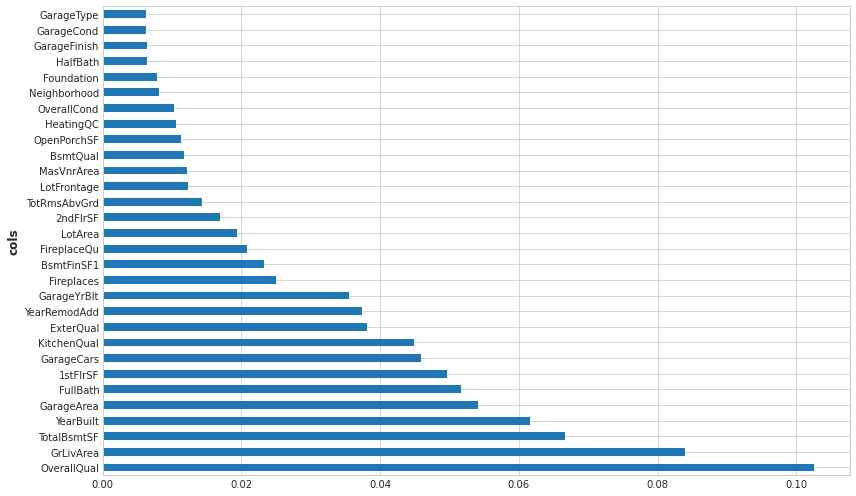

In [29]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [30]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

36

In [31]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [32]:
rfr = rf(xs_imp, y)
m_rmse(rfr, xs_imp, y), m_rmse(rfr, valid_xs_imp, valid_y)

(0.103372, 0.1415)

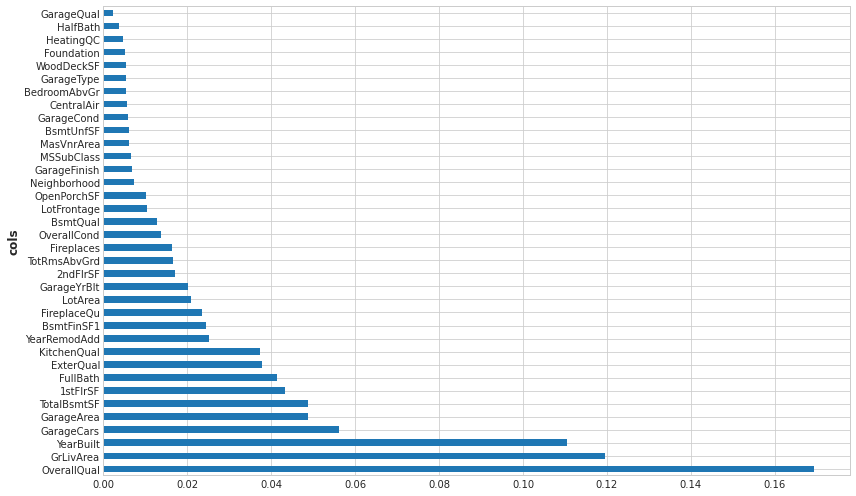

In [33]:
plot_fi(rf_feat_importance(rfr, xs_imp));

In [34]:
len(xs.columns), len(xs_imp.columns)

(94, 36)

### Removing Redundant Features

In [35]:
#!pip install -Uqq fastbook
#import fastbook
#from fastbook import *

In [36]:
#cluster_columns(xs_imp)

In [37]:
def get_oob(df):
    rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100, min_samples_split=2, min_samples_leaf=15,
       max_features='sqrt',max_depth=20, bootstrap=True, oob_score=True)
    rfr.fit(df, y)
    return rfr.oob_score_

In [38]:
get_oob(xs_imp)

0.8295180409724319

In [39]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'FireplaceQu','Fireplaces',
    'GrLivArea', 'TotRmsAbvGrd', 
    'GarageArea', 'GarageCars',
    'GarageYrBlt', 'YearBuilt',
    '1stFlrSF', 'TotalBsmtSF')}

{'FireplaceQu': 0.8239107559790493,
 'Fireplaces': 0.825261710439413,
 'GrLivArea': 0.817419079997821,
 'TotRmsAbvGrd': 0.8230361548981222,
 'GarageArea': 0.8299431469492238,
 'GarageCars': 0.8281749015800218,
 'GarageYrBlt': 0.8273684036721549,
 'YearBuilt': 0.824200241328522,
 '1stFlrSF': 0.8241989949253787,
 'TotalBsmtSF': 0.8232687494903671}

In [40]:
to_drop = ['FireplaceQu', 'TotRmsAbvGrd', 'GarageArea', 'GarageYrBlt', '1stFlrSF']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8238984791552896

In [41]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [42]:
# saving final versions

save_pickle('/kaggle/working/xs_final.pkl', xs_final)
save_pickle('/kaggle/working/valid_xs_final.pkl', valid_xs_final)

In [43]:
# loading them back

xs_final = load_pickle('/kaggle/working/xs_final.pkl')
valid_xs_final = load_pickle('/kaggle/working/valid_xs_final.pkl')

In [44]:
rfr = rf(xs_final, y)
m_rmse(rfr, xs_final, y), m_rmse(rfr, valid_xs_final, valid_y)

(0.105279, 0.141452)

### Partial Dependence

As we've seen, the two most important predictors are `GrLivArea` and `OverallQual`. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas value_counts method), to see how common each category is:

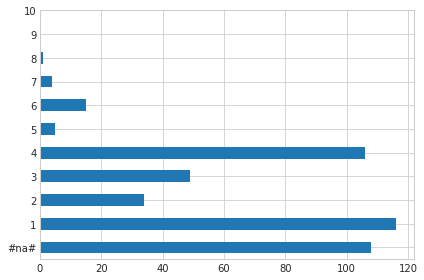

In [45]:
p = valid_xs_final['OverallQual'].value_counts(sort=False).plot.barh()
c = to.classes['OverallQual']
plt.yticks(range(len(c)), c);

#na#: label fastai applies to missing values.

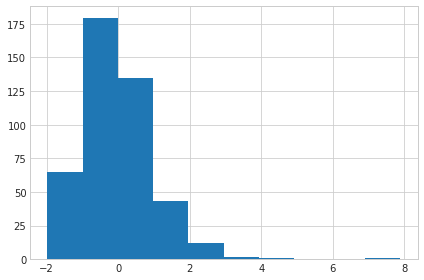

In [46]:
ax = valid_xs_final['GrLivArea'].hist()

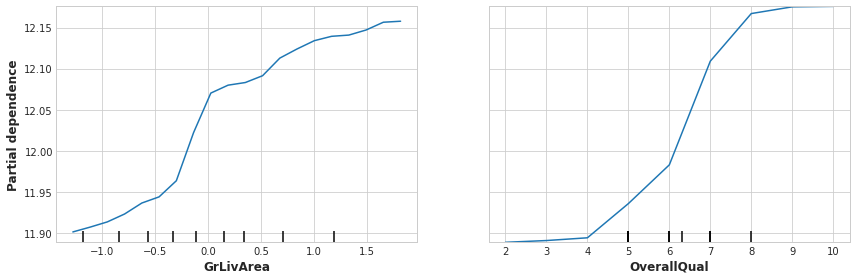

In [47]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rfr, valid_xs_final, ['GrLivArea','OverallQual'],
                        grid_resolution=20, ax=ax);

### Test set predictions with RFR

In [48]:
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

df_test['DateSold'] = pd.to_datetime(df_test.YrSold.astype(str) + '/' + df_test.MoSold.astype(str) + '/01')
add_datepart(df_test, 'DateSold')

cont_test,cat_test = cont_cat_split(df_test, max_card=25, dep_var=None)
procs_test = [Categorify, FillMissing, Normalize]
to_test = TabularPandas(df_test, procs_test, cat_test, cont_test, y_names=None)

xs_test = to_test.train.xs[list(xs_final.columns)]

predicted_prices = rfr.predict(xs_test)

my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': np.exp(predicted_prices)})

my_submission.to_csv('submission_rfr.csv', index=False)

## XGBoost

In [49]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [50]:
xgr = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgr, xs, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.148 (0.021)


In [51]:
xgr = XGBRegressor().fit(xs, y)
m_rmse(xgr, xs, y), m_rmse(xgr, valid_xs, valid_y)

(0.004029, 0.135155)

In [52]:
# Start with original training and validation set: (xs,y), (valid_xs,valid_y) 
# and perform a hyperparameter-tuning

"""
from xgboost import XGBRegressor
from xgboost import plot_importance


params = {"learning_rate"    : [ 0.001, 0.01, 0.1, 1.0 ],
          "max_depth"        : [ 3, 6, 9 ],
          "n_estimators"     : [ 50, 100, 500 ]}

xgbr = XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_root_mean_squared_error',
                   n_jobs=-1)

clf.fit(xs, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_))
"""

'\nfrom xgboost import XGBRegressor\nfrom xgboost import plot_importance\n\n\nparams = {"learning_rate"    : [ 0.001, 0.01, 0.1, 1.0 ],\n          "max_depth"        : [ 3, 6, 9 ],\n          "n_estimators"     : [ 50, 100, 500 ]}\n\nxgbr = XGBRegressor(seed = 20)\nclf = GridSearchCV(estimator=xgbr, \n                   param_grid=params,\n                   scoring=\'neg_root_mean_squared_error\',\n                   n_jobs=-1)\n\nclf.fit(xs, y)\nprint("Best parameters:", clf.best_params_)\nprint("Lowest RMSE: ", (-clf.best_score_))\n'

In [53]:
# Saving the output so that we don't run the above cell multiple times

#Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
#Lowest RMSE:  0.13391363620758057

In [54]:
xgr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=500).fit(xs, y)
m_rmse(xgr, xs, y), m_rmse(xgr, valid_xs, valid_y)

(0.03281, 0.121927)

### Performing feature importance and dropping redundant featurse

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

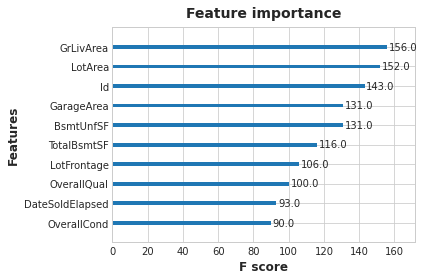

In [55]:
plot_importance(xgr, max_num_features=10)

In [56]:
# Model selection

# Credit: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

import warnings
warnings.filterwarnings('ignore')

# use feature importance for feature selection
from numpy import sort
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel

# split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=7)
# fit model on all training data
xgr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=500)
xgr.fit(xs, y)
# make predictions for test data and evaluate
y_pred = xgr.predict(valid_xs)
predictions = [round(value) for value in y_pred]
rmse_score = np.sqrt(mean_squared_error(valid_y, predictions))
print("RMSE: %.2f" % (rmse_score))
# Fit model using each importance as a threshold
thresholds = sort(xgr.feature_importances_)
for thresh in thresholds[::-1][0:60]:
	# select features using threshold
	selection = SelectFromModel(xgr, threshold=thresh, prefit=True)
	select_X_train = selection.transform(xs)
	# train model
	selection_model = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=500)
	selection_model.fit(select_X_train, y)
	# eval model
	select_X_test = selection.transform(valid_xs)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	rmse_score = np.sqrt(mean_squared_error(valid_y, predictions))
	print("Thresh=%.3f, n=%d, RMSE: %.2f" % (thresh, select_X_train.shape[1], rmse_score))

RMSE: 0.29
Thresh=0.149, n=1, RMSE: 0.36
Thresh=0.116, n=2, RMSE: 0.35
Thresh=0.112, n=3, RMSE: 0.34
Thresh=0.073, n=4, RMSE: 0.33
Thresh=0.052, n=5, RMSE: 0.31
Thresh=0.039, n=6, RMSE: 0.30
Thresh=0.036, n=7, RMSE: 0.31
Thresh=0.034, n=8, RMSE: 0.31
Thresh=0.032, n=9, RMSE: 0.31
Thresh=0.031, n=10, RMSE: 0.30
Thresh=0.028, n=11, RMSE: 0.30
Thresh=0.023, n=12, RMSE: 0.30
Thresh=0.016, n=13, RMSE: 0.30
Thresh=0.014, n=14, RMSE: 0.30
Thresh=0.014, n=15, RMSE: 0.29
Thresh=0.013, n=16, RMSE: 0.29
Thresh=0.011, n=17, RMSE: 0.29
Thresh=0.010, n=18, RMSE: 0.29
Thresh=0.010, n=19, RMSE: 0.29
Thresh=0.009, n=20, RMSE: 0.29
Thresh=0.008, n=21, RMSE: 0.29
Thresh=0.007, n=22, RMSE: 0.29
Thresh=0.007, n=23, RMSE: 0.29
Thresh=0.006, n=24, RMSE: 0.29
Thresh=0.006, n=25, RMSE: 0.29
Thresh=0.006, n=26, RMSE: 0.29
Thresh=0.006, n=27, RMSE: 0.29
Thresh=0.005, n=28, RMSE: 0.29
Thresh=0.005, n=29, RMSE: 0.29
Thresh=0.005, n=30, RMSE: 0.29
Thresh=0.004, n=31, RMSE: 0.29
Thresh=0.004, n=32, RMSE: 0.29
Thresh

In [57]:
to_keep = fi[fi.imp>0.01].cols
print(len(to_keep))

xs_xgr_final = xs[to_keep]

xgr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=500)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgr, xs_xgr_final, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

24
Mean RMSE: 0.139 (0.021)


### Test set predictions with XGBoost

In [58]:
xgr = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=500).fit(xs_xgr_final, y)
m_rmse(xgr, xs_xgr_final, y), m_rmse(xgr, valid_xs[list(xs_xgr_final.columns)], valid_y)

(0.041927, 0.127449)

In [59]:
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

df_test['DateSold'] = pd.to_datetime(df_test.YrSold.astype(str) + '/' + df_test.MoSold.astype(str) + '/01')
add_datepart(df_test, 'DateSold')

cont_test,cat_test = cont_cat_split(df_test, max_card=25, dep_var=None)
procs_test = [Categorify, FillMissing, Normalize]
to_test = TabularPandas(df_test, procs_test, cat_test, cont_test, y_names=None)

xs_test = to_test.train.xs[list(xs_xgr_final.columns)]

predicted_prices = xgr.predict(xs_test)

my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': np.exp(predicted_prices)})

my_submission.to_csv('submission_xgr.csv', index=False)

## Neural Network [WIP]

In [60]:
df_nn = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

df_nn['DateSold'] = pd.to_datetime(df_nn.YrSold.astype(str) + '/' + df_nn.MoSold.astype(str) + '/01')
df_nn.drop(['MoSold', 'YrSold'], axis=1, inplace=True)
add_datepart(df_nn, 'DateSold')

df_nn[dep_var] = np.log(df_nn[dep_var])

cont_nn,cat_nn = cont_cat_split(df_nn, max_card=25, dep_var=dep_var)
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [61]:
dls = to_nn.dataloaders(bs=64)

In [62]:
dls.show_batch()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,3SsnPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,DateSoldYear,DateSoldMonth,DateSoldWeek,DateSoldDay,DateSoldDayofweek,DateSoldDayofyear,DateSoldIs_month_end,DateSoldIs_month_start,DateSoldIs_quarter_end,DateSoldIs_quarter_start,DateSoldIs_year_end,DateSoldIs_year_start,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,DateSoldElapsed,SalePrice
0,90,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,5,5,Gable,CompShg,Plywood,Plywood,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,0,2,0,2,0,4,2,TA,8,Typ,0,#na#,Detchd,Unf,2,TA,TA,Y,0,0,#na#,#na#,#na#,0,WD,Family,2006,7,26,1,5,182,False,True,False,True,False,False,False,False,False,454.999995,63.000000,9297.000039,1976.000000,1976.000000,-0.000004,1606.000009,0.000002,121.999987,1727.999993,1727.999983,0.000012,1727.999995,1976.000000,559.999999,-0.000003,-0.000001,-6.601337e-07,2.815347e-07,1.151712e+09,12.144197
1,60,RL,Pave,#na#,IR3,HLS,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Ex,Gd,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,0,2,1,3,1,Gd,9,Typ,1,Gd,BuiltIn,RFn,2,TA,TA,Y,0,0,#na#,#na#,#na#,0,New,Partial,2006,9,35,1,4,244,False,True,False,False,False,False,False,False,False,1108.000006,168.000003,23257.000026,2006.000000,2005.999999,-0.000004,0.000002,0.000002,867.999992,868.000000,887.000005,1134.000021,2021.000004,2006.000000,422.000000,-0.000003,100.000000,-6.601337e-07,2.815347e-07,1.157069e+09,12.523526
2,70,RH,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,2Story,6,8,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,BLQ,Unf,GasA,TA,N,SBrkr,0,0,0,2,0,4,1,Fa,7,Typ,0,#na#,Detchd,Unf,1,TA,TA,P,0,0,#na#,#na#,#na#,0,WD,Normal,2008,3,9,1,5,61,False,True,False,False,False,False,True,False,False,840.999998,69.000000,12154.999980,1925.000000,1949.999999,-0.000004,156.000003,0.000002,516.000001,672.000007,809.999998,672.000013,1482.000000,1933.999999,399.999998,-0.000003,-0.000001,2.540000e+02,2.815347e-07,1.204330e+09,11.849398
3,30,RH,Pave,#na#,Reg,Bnk,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,1Story,3,6,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,BrkTil,TA,TA,No,Rec,Unf,GasA,Ex,Y,SBrkr,0,0,0,1,0,3,1,Gd,6,Typ,0,#na#,#na#,#na#,0,#na#,#na#,Y,0,0,#na#,#na#,#na#,0,WD,Normal,2007,5,18,1,1,121,False,True,False,False,False,False,False,False,True,1326.999995,70.000000,4270.000129,1931.000000,2005.999999,-0.000004,543.999999,0.000002,0.000015,543.999997,773.999987,0.000012,773.999995,1978.000000,0.000008,-0.000003,-0.000001,2.860000e+02,2.815347e-07,1.177978e+09,11.277204
4,80,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,Gable,CompShg,Plywood,Plywood,None,TA,TA,CBlock,TA,TA,Av,ALQ,Unf,GasA,TA,Y,SBrkr,0,1,0,1,0,3,1,TA,6,Typ,1,Po,Attchd,Fin,1,TA,TA,Y,0,576,Gd,GdPrv,#na#,0,WD,Normal,2008,7,27,1,1,183,False,True,False,True,False,False,False,False,False,1170.999987,76.000000,9879.999997,1977.000000,1977.000000,-0.000004,521.999997,0.000002,574.000000,1096.000003,1117.999998,0.000012,1118.000005,1977.000000,357.999998,202.999998,-0.000001,-6.601337e-07,2.815347e-07,1.214870e+09,12.049418
5,50,RL,Pave,#na#,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,7,9,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,Gd,CBlock,TA,TA,No,BLQ,

In [63]:
# It's a good idea to set y_range for regression models, so let's find the min and max of our dependent variable:

y = to_nn.train.y
y.min(),y.max()

(10.46024227142334, 13.534473419189453)

In [64]:
learn = tabular_learner(dls, y_range=(10,14),
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.001737800776027143)

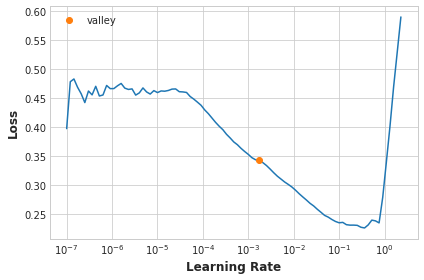

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.220626,0.134788,00:00
1,0.126832,0.062101,00:00
2,0.084663,0.040573,00:00
3,0.060534,0.028233,00:00
4,0.045184,0.028266,00:00


In [67]:
dl = learn.dls.test_dl(valid_xs)
pred = learn.get_preds(dl=dl)[0].numpy()
#rmse(pred.T.flatten(),valid_y.values)
#round(math.sqrt(((pred-y)**2).mean()), 6)
math.sqrt(((pred.T.flatten() - valid_y.values)**2.).mean())

2.0695869757989707

In [68]:
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

df_test['DateSold'] = pd.to_datetime(df_test.YrSold.astype(str) + '/' + df_test.MoSold.astype(str) + '/01')
add_datepart(df_test, 'DateSold')

cont_test,cat_test = cont_cat_split(df_test, max_card=25, dep_var=None)
procs_test = [Categorify, FillMissing, Normalize]
to_test = TabularPandas(df_test, procs_test, cat_test, cont_test, y_names=None)

xs_test = to_test.train.xs#[list(xs_xgr_final.columns)]

In [69]:
dl = learn.dls.test_dl(xs_test)
learn.get_preds(dl=dl)

(tensor([[10.0048],
         [10.0048],
         [10.0045],
         ...,
         [10.0051],
         [10.0045],
         [10.0046]]),
 None)

In [70]:
predicted_prices = learn.get_preds(dl=dl)

In [71]:
np.shape(predicted_prices[0].numpy().flatten())

(1459,)

In [72]:
my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': np.exp(predicted_prices[0].numpy().flatten())})
my_submission.to_csv('submission_nn.csv', index=False)

In [73]:
learn.save('nn')

Path('models/nn.pth')

| Model | Training Score | Valid Score | Test Score |
|--|--|--|--|
| DecisionTreeRegressor | 0.215144 | 0.234927 | not submitted |
| RandomForestRegressor | 0.105759 | 0.141392 | 0.17211 |
| XGBoost | 0.047828 | 0.131914 | 0.14819 |
| Neural Network (WIP) | XX | 2.0703435931479985 | 2.05518 | 